In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

In [5]:
df = pd.read_csv('./data/autodeskuni.csv')

## Initial Data Check
First of all I'd like to check the quality of data I scraped and figure out whether it's OK to work with.

In [6]:
df.count()

city             6026
description      6013
key_learnings    5764
tags_industry    5823
tags_product     5566
tags_topics      5988
title            6026
year             6026
dtype: int64

In [7]:
df.isnull().sum(axis = 0)

city               0
description       13
key_learnings    262
tags_industry    203
tags_product     460
tags_topics       38
title              0
year               0
dtype: int64

In [8]:
df.city.value_counts()

Las Vegas                       5134
Virtual                          413
London                           268
Connect and Construct Summit      80
Middle East                       56
Australia                         44
Forge DevCon                      31
Name: city, dtype: int64

In [9]:
df.groupby(['year', 'city']).count()

description  key_learnings  tags_industry  \
year city                                                                      
2011 Las Vegas                              23             23             23   
2012 Las Vegas                             362            358            350   
2013 Las Vegas                             576            572            514   
2014 Las Vegas                             640            593            587   
2015 Australia                              43              2             43   
     Las Vegas                             714            700            692   
2016 Las Vegas                             683            669            675   
2017 Australia                               1              0              1   
     Las Vegas                             724            687            701   
     London                                 77             71             77   
2018 Las Vegas                             738            724            734   
     London                                 90             73             86   
     Middle East                             1              0              1   
2019 Connect and Construct Summit           80             77             80   
     Forge DevCon                           31             30             31   
     Las Vegas                             662            657            673   
     London                                100             88             92   
     Middle East                            55             28             55   
2020 Virtual                               413            412            408   

                                   tags_product  tags_topics  title  
year city                                                            
2011 Las Vegas                               23           23     23  
2012 Las Vegas                              323          360    362  
2013 Las Vegas                              490          575    576  
2014 Las Vegas                              600          638    640  
2015 Australia                               24           36     43  
     Las Vegas                              675          711    714  
2016 Las Vegas                              615          676    683  
2017 Australia                                0            0      1  
     Las Vegas                              694          721    725  
     London                                  72           76     77  
2018 Las Vegas                              710          736    738  
     London                                  66           87     90  
     Middle East                              0            0      1  
2019 Connect and Construct Summit            63           80     80  
     Forge DevCon                            31           31     31  
     Las Vegas                              650          671    673  
     London                                  91          100    101  
     Middle East                             45           54     55  
2020 Virtual                                394          413    413

I can see that some locations are not geographic: both Forge DevCon and Connect and Construct Summit took place only once in 2019, so I googled them and found out that they were a part of Autodesk University Las Vegas 2019, so I'll just substitute these values with "Las Vegas".

In [10]:
df['city'] = df['city'].replace(['Forge DevCon', 'Connect and Construct Summit'], 'Las Vegas')

In [11]:
df.groupby(['year']).count()

,city,description,key_learnings,tags_industry,tags_product,tags_topics,title
year,,,,,,,
2011,23,23,23,23,23,23,23
2012,362,362,358,350,323,360,362
2013,576,576,572,514,490,575,576
2014,640,640,593,587,600,638,640
2015,757,757,702,735,699,747,757
2016,683,683,669,675,615,676,683
2017,803,802,758,779,766,797,803
2018,829,829,797,821,776,823,829
2019,940,928,880,931,880,936,940


And I will also get rid of Australia 2017 and Middle East 2018 because they only have 1 record each and wouldn't really give any relevant information (I checked them out on the website).

In [12]:
i = df[(df['year'] == 2017) & (df['city'] == 'Australia')].index[0]
df = df.drop(i)

In [13]:
i = df[(df['year'] == 2018) & (df['city'] == 'Middle East')].index[0]
df = df.drop(i)

In [14]:
df.groupby(['year', 'city']).count()

description  key_learnings  tags_industry  tags_product  \
year city                                                                   
2011 Las Vegas             23             23             23            23   
2012 Las Vegas            362            358            350           323   
2013 Las Vegas            576            572            514           490   
2014 Las Vegas            640            593            587           600   
2015 Australia             43              2             43            24   
     Las Vegas            714            700            692           675   
2016 Las Vegas            683            669            675           615   
2017 Las Vegas            724            687            701           694   
     London                77             71             77            72   
2018 Las Vegas            738            724            734           710   
     London                90             73             86            66   
2019 Las Vegas            773            764            784           744   
     London               100             88             92            91   
     Middle East           55             28             55            45   
2020 Virtual              413            412            408           394   

                  tags_topics  title  
year city                             
2011 Las Vegas             23     23  
2012 Las Vegas            360    362  
2013 Las Vegas            575    576  
2014 Las Vegas            638    640  
2015 Australia             36     43  
     Las Vegas            711    714  
2016 Las Vegas            676    683  
2017 Las Vegas            721    725  
     London                76     77  
2018 Las Vegas            736    738  
     London                87     90  
2019 Las Vegas            782    784  
     London               100    101  
     Middle East           54     55  
2020 Virtual              413    413

#### Since there are not so many items from London and Middle East comparing to Las Vegas I decided not to group them by location.

## Extract tags
All tags I collected came in lists delimited by "|", so I want to extract lists of unique tags grouped by product, topic and industry.

In [15]:
topics = df['tags_topics'].tolist()
industry = df['tags_industry'].tolist()
product = df['tags_product'].tolist()

In [16]:
def unique_tags(lst):
    lst = [str(i).split("|") for i in lst] #flatten
    lst = set([j for i in lst for j in i if j != "nan"])#unique vals, exclude "nan"
    return lst

In [17]:
tags_topics_unique = unique_tags(topics)
tags_industry_unique = unique_tags(industry)
tags_product_unique = unique_tags(product)

In product tags, there are groups of tags that refer to the same product, so I will merge them all together in the data frame (only autocad, bim 360 and revit).

In [46]:
list_autocad = [i for i in tags_product_unique if re.findall('autocad', i)]
list_bim360 = [i for i in tags_product_unique if re.findall('bim 360', i)]
list_revit = [i for i in tags_product_unique if re.findall('revit', i)]
list_navis = [i for i in tags_product_unique if re.findall('navisworks', i)]

In [47]:
for item in list_autocad:
    df['tags_product'] = df['tags_product'].str.replace(item, 'autocad')

for item in list_bim360:
    df['tags_product'] = df['tags_product'].str.replace(item, 'bim 360')
    
for item in list_revit:
    df['tags_product'] = df['tags_product'].str.replace(item, 'revit')

I'll also merge 'ar/vr', 'augmented reality' and 'virtual reality' and 'robotics' and 'robots' in topics tags.

In [48]:
list_ar_vr = ['augmented reality', 'virtual reality']
for item in list_ar_vr:
    df['tags_topics'] = df['tags_topics'].str.replace(item, 'ar/vr')
    
df['tags_topics'] = df['tags_topics'].str.replace('robots', 'robotics')

In [49]:
#extract unique tags again
product = df['tags_product'].tolist()
topics = df['tags_topics'].tolist()
tags_product_unique = unique_tags(product)
tags_topics_unique = unique_tags(topics)

## Selecting desired tags

There are a lot of tags but there are a only a few that I'm interested in, so I'll cherry-pick them:

In [66]:
programming_selection = ['python', 'c#', 'revit api']
product_selection = ['autocad', 'bim 360', 'civil 3d', 'dynamo studio', 'revit', 'navisworks']
topics_selection = ['3d printing', 'ar/vr', 'artificial intelligence', 'big data', 
                    'laser scanning', 'machine learning', 'robotics', 'software development']

Creating new columns with 0/1 values for each of selected tags.

In [67]:
for i in product_selection:
    df[f'{i}'] = np.where(df['tags_product'].str.contains(i), 1, 0)

for i in topics_selection:
    df[f'{i}'] = np.where(df['tags_topics'].str.contains(i), 1, 0)
    
for i in programming_selection:
    df[f'{i}'] = np.where(df['description'].str.lower().str.contains(i), 1, 0)

Also create separate columns for locations.

In [68]:
locations = list(df['city'].unique())
for i in locations:
    df[f'{i}'] = np.where(df['city'].str.match(i), 1, 0)

And Industries.

In [69]:
for i in tags_industry_unique:
    df[f'{i}'] = np.where(df['tags_industry'].str.contains(i), 1, 0)

In [70]:
tags_product_unique

{'123d',
 '3ds max',
 'a360',
 'advance steel',
 'alias autostudio',
 'alias products',
 'alias speedform',
 'arnold',
 'artcam',
 'assemble products',
 'autocad',
 'autodesk nastran',
 'bim 360',
 'buzzsaw',
 'cfd',
 'civil 3d',
 'configurator 360',
 'dwg trueview',
 'dynamo studio',
 'eagle',
 'ecotect analysis',
 'fabrication cadmep',
 'fabrication camduct',
 'fabrication estmep',
 'fabrication fabmep',
 'fabrication remoteentry',
 'factory design utilities',
 'fbx',
 'featurecam',
 'flame',
 'forge',
 'formit pro',
 'fusion 360',
 'fusion lifecycle',
 'fusion production',
 'helius pfa',
 'hsmworks',
 'infrastructure map server',
 'infraworks',
 'insight',
 'inventor',
 'inventor hsm',
 'inventor lt',
 'inventor nastran',
 'inventor professional',
 'maya',
 'moldflow adviser',
 'moldflow insight',
 'moldflow products',
 'motionbuilder',
 'mudbox',
 'navisworks manage',
 'navisworks products',
 'navisworks simulate',
 'netfabb',
 'plangrid',
 'point layout',
 'powerinspect',
 'powerm

I'll save selected columns in separate list for convenience:

In [71]:
cols_product = ['autocad', 'bim 360', 'civil 3d', 'revit', 'navisworks']
cols_topic_data = ['artificial intelligence', 'big data', 'machine learning']
cols_topic_other = ['3d printing', 'ar/vr', 'laser scanning', 'robotics']
cols_programming = ['revit api', 'dynamo studio', 'python', 'c#', 'software development']
cols_industry = list(tags_industry_unique)

## Plotting Graphs

First I want to see how many presentations were introduced at the event every year by locations.
I can't be sure that every presentation was published on the website so I'll just assume that most of them were and analyze the data based on this assumption.

([<matplotlib.axis.XTick at 0x1f7ed919d90>,
 <a list of 10 Text major ticklabel objects>)

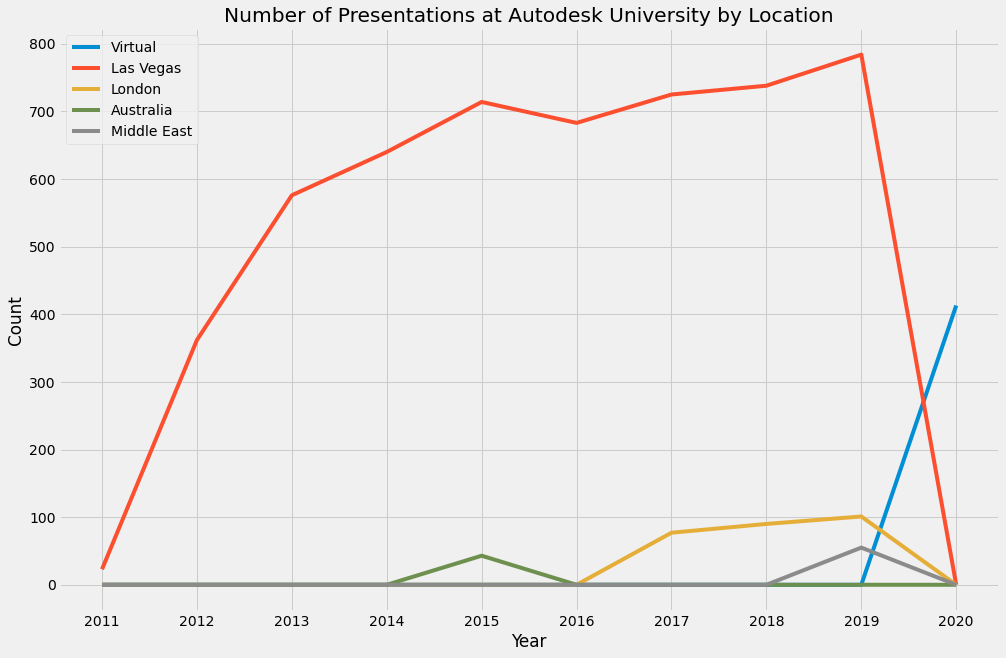

In [72]:
df[['year']+locations].groupby('year').sum().plot(figsize=(15,10), kind = 'line')
plt.title('Number of Presentations at Autodesk University by Location')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(list(range(2011, 2021)))

I can see that events in Australia, London and Middle East were quite small and did not occur every year, or just didn't get published. So I will just combine them all together.

The event shows big growth across the years so I will need to normalize tag counts by total number ot presentations each year:

In [73]:
df_percent = df.groupby('year').sum() * 100 / df.groupby('year').count()
df_percent

,3d printing,Australia,Las Vegas,London,Middle East,Virtual,aerospace,ar/vr,architecture services,artificial intelligence,...,robotics,software,software development,structural engineering,tags_industry,tags_product,tags_topics,title,transportation,utilities & telecom
year,,,,,,,,,,,,,,,,,,,,,
2011,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.347826,0.000000,...,0.000000,0.000000,4.347826,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
2012,1.104972,0.000000,100.000000,0.000000,0.000000,0.0,4.696133,1.104972,56.077348,0.552486,...,1.104972,9.944751,2.209945,3.591160,NaN,NaN,NaN,NaN,4.696133,12.983425
2013,1.562500,0.000000,100.000000,0.000000,0.000000,0.0,33.159722,0.694444,59.375000,0.173611,...,0.694444,21.875000,1.388889,11.458333,NaN,NaN,NaN,NaN,11.284722,19.791667
2014,1.718750,0.000000,100.000000,0.000000,0.000000,0.0,8.281250,0.937500,46.250000,0.312500,...,0.468750,40.781250,1.718750,12.500000,NaN,NaN,NaN,NaN,9.687500,12.343750
2015,3.170410,5.680317,94.319683,0.000000,0.000000,0.0,5.812417,3.038309,27.741083,1.585205,...,2.509908,34.742404,2.642008,10.303831,NaN,NaN,NaN,NaN,3.434610,8.982827
2016,3.221083,0.000000,100.000000,0.000000,0.000000,0.0,3.221083,5.856515,28.257687,1.317716,...,1.903367,38.799414,9.809663,6.295754,NaN,NaN,NaN,NaN,9.663250,4.685212
2017,4.738155,0.000000,90.399002,9.600998,0.000000,0.0,4.364090,11.471322,26.932668,2.743142,...,1.620948,27.930175,11.596010,10.224439,NaN,NaN,NaN,NaN,10.972569,7.107232
2018,3.381643,0.000000,89.130435,10.869565,0.000000,0.0,2.536232,8.574879,27.777778,2.536232,...,1.811594,26.086957,13.768116,6.884058,NaN,NaN,NaN,NaN,5.434783,3.743961
2019,4.255319,0.000000,83.404255,10.744681,5.851064,0.0,2.872340,8.936170,26.595745,3.085106,...,2.553191,24.468085,14.361702,7.021277,NaN,NaN,NaN,NaN,7.021277,3.617021


Now I'm ready to plot my graphs and see what's going on with the technology trends.

There are quite a lot of different industries they talk about at the event, so I selected top 7 of them to show the trends for.

#### Important note: One presentation can have multiple tags from one group .

In [74]:
industry_top = df[cols_industry].sum().sort_values(ascending=False).head(6).index.tolist()

([<matplotlib.axis.XTick at 0x1f7e9565c40>,
 <a list of 10 Text major ticklabel objects>)

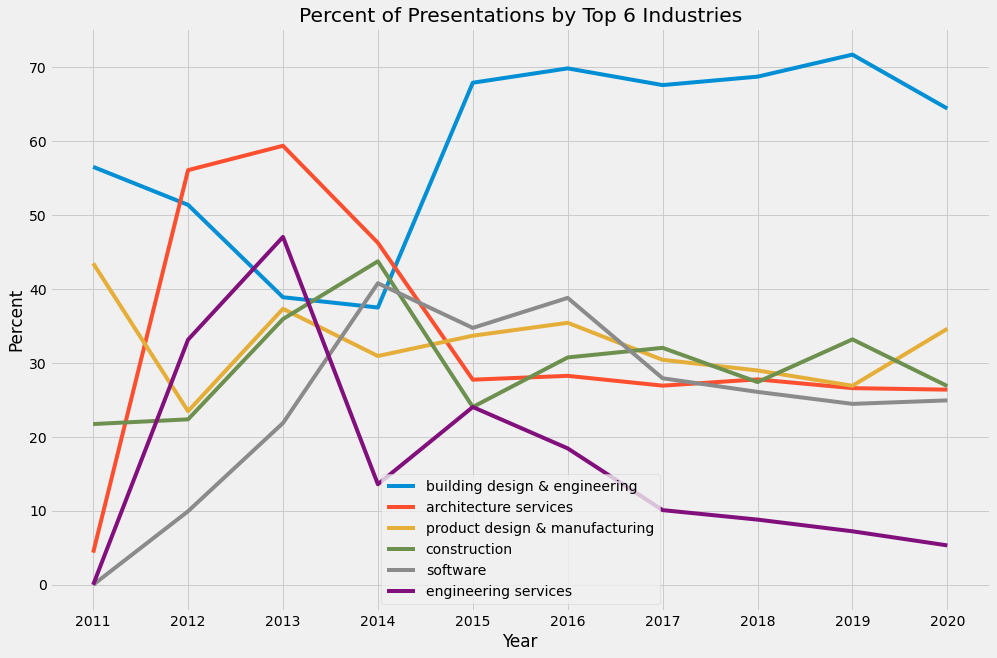

In [75]:
df_percent[industry_top].groupby('year').sum().plot(figsize=(15,10), kind = 'line')
plt.title('Percent of Presentations by Top 6 Industries')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.xticks(list(range(2011, 2021)))

([<matplotlib.axis.XTick at 0x1f7e95257f0>,
 <a list of 10 Text major ticklabel objects>)

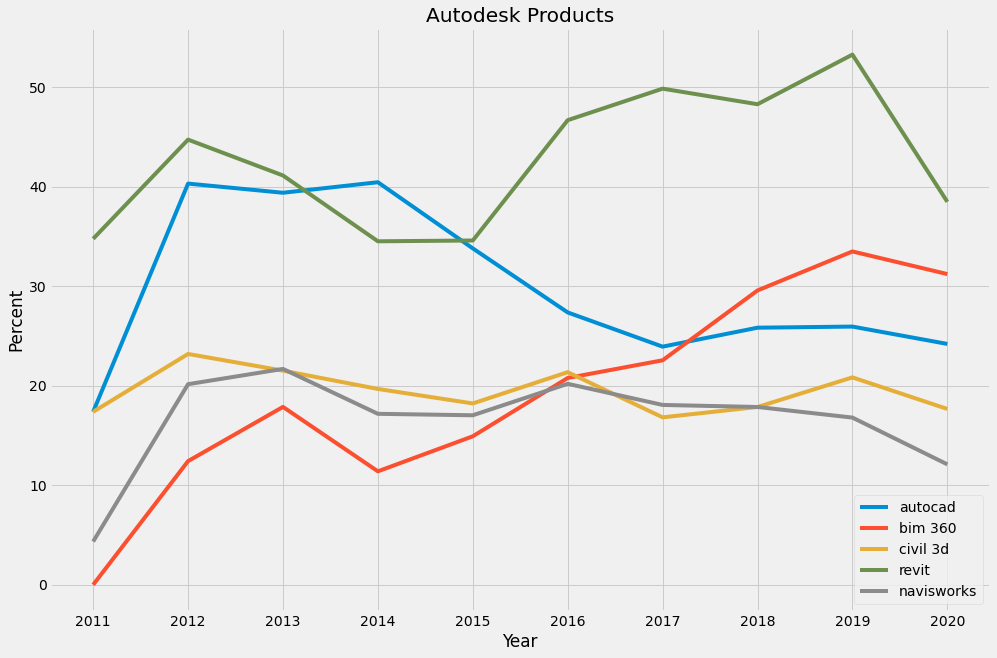

In [76]:
df_percent[cols_product].plot(figsize=(15,10), kind = 'line')
plt.title('Autodesk Products')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.xticks(list(range(2011, 2021)))

([<matplotlib.axis.XTick at 0x1f7e8c08dc0>,
 <a list of 10 Text major ticklabel objects>)

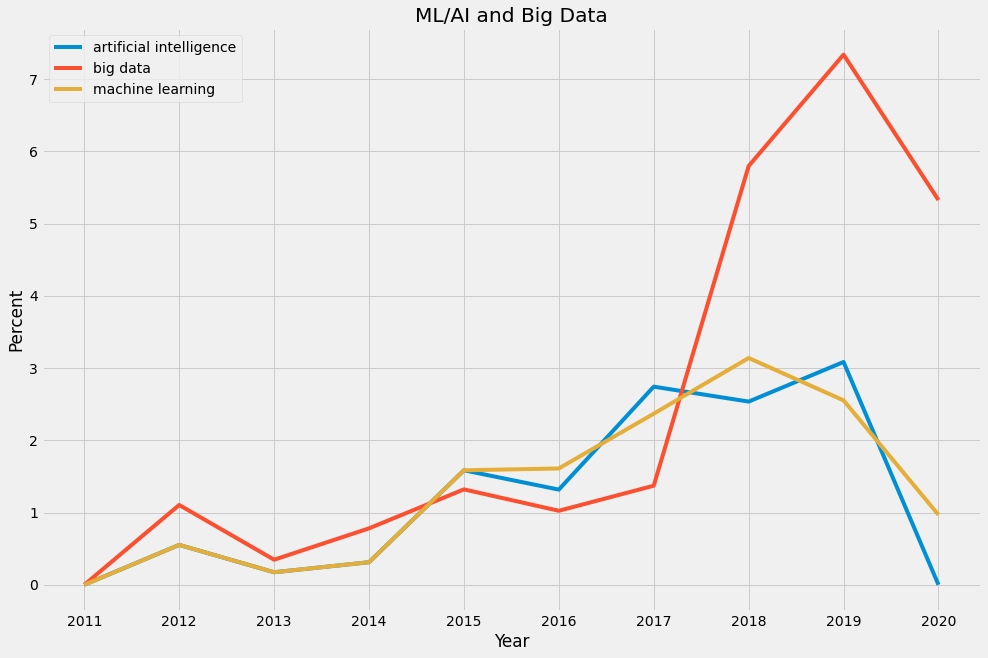

In [77]:
df_percent[cols_topic_data].plot(figsize=(15,10), kind = 'line')
plt.title('ML/AI and Big Data')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.xticks(list(range(2011, 2021)))

([<matplotlib.axis.XTick at 0x1f7e95c3760>,
 <a list of 10 Text major ticklabel objects>)

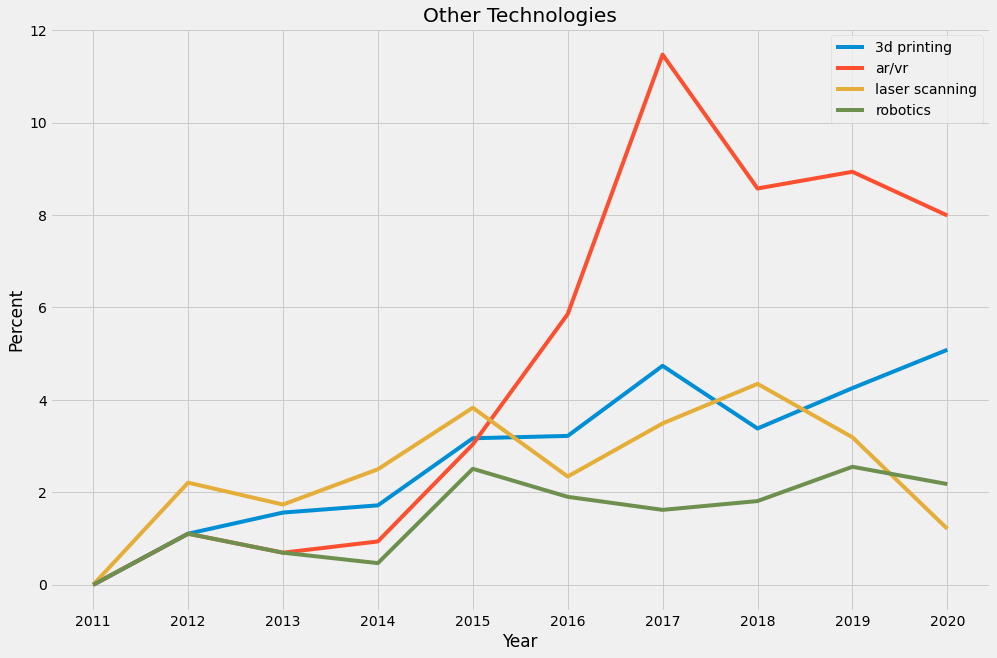

In [78]:
df_percent[cols_topic_other].plot(figsize=(15,10), kind = 'line')
plt.title('Other Technologies')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.xticks(list(range(2011, 2021)))

([<matplotlib.axis.XTick at 0x1f7ed88d8b0>,
 <a list of 10 Text major ticklabel objects>)

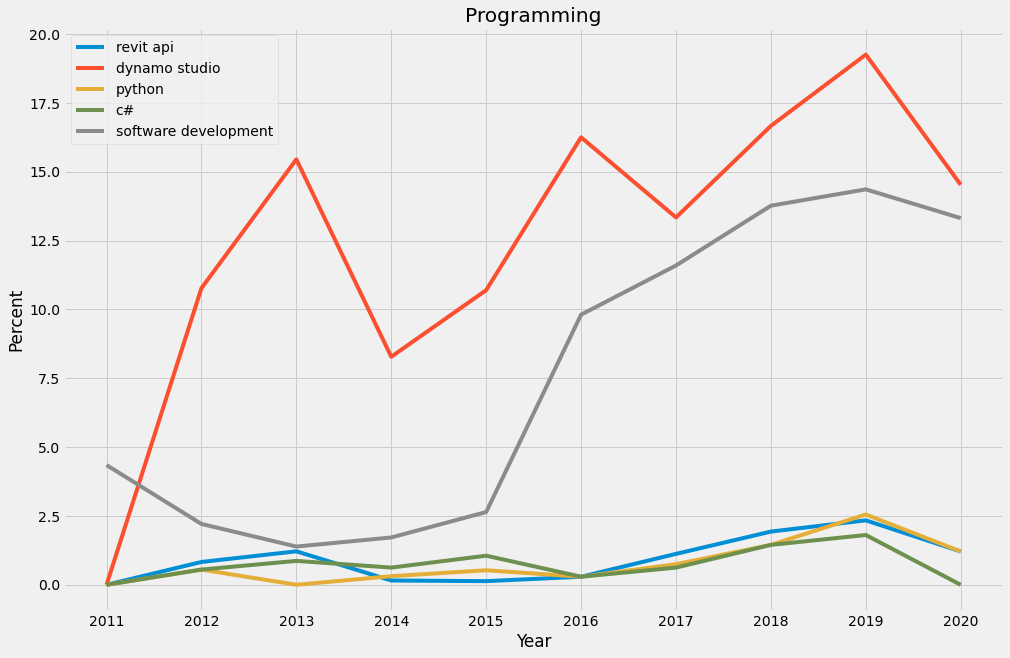

In [79]:
df_percent[cols_programming].plot(figsize=(15,10), kind = 'line')
plt.title('Programming')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.xticks(list(range(2011, 2021)))